In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout, Softmax
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback
from keras.metrics import Metric
from tensorflow import keras

from time import perf_counter
import functools

In [2]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [3]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\amitt\AppData\Local\Temp\ipykernel_5560\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [4]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [5]:
def drop_res(x, blur_factor=10):
    spec_x = x[:,:(x.shape[1]//blur_factor * blur_factor)]
    blur_x = (spec_x.flatten()
     .reshape((spec_x.shape[0] * spec_x.shape[1] // blur_factor, blur_factor))
     .mean(axis=1)
     .reshape((spec_x.shape[0], spec_x.shape[1] // blur_factor))
    )

    return blur_x

In [6]:
fuzzy_win = 5

In [7]:
def cnn_reshape(x):
    return x.reshape((-1, x.shape[1], 1))

In [8]:
blur_factor = 4

# x = drop_res(fuzzy_dx3, blur_factor=blur_factor)
x = df[spec_cols].values
y = df[stresses].values

x /= x.max()

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2)

In [9]:
class Accuracy(Metric):
    def __init__(self, name='accuracy', **kwargs):
        super().__init__(name=name, **kwargs)
        self.accuracy = self.add_variable(
            shape=(),
            initializer='zeros',
            name='accuracy'
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = tf.cast(tf.reduce_all((y_pred > .5) == y_true, axis=1), tf.float32)
        
        self.accuracy.assign(tf.reduce_mean(p))

    def result(self):
        return self.accuracy

In [10]:
@functools.cache
def fuzzy_dx_init(shape, dtype=None):
    half_shape = list(shape)
    half_shape[0] //= 2
    half_shape = tuple(half_shape)
    return np.vstack((np.ones(half_shape) * -1/half_shape[0], np.ones(half_shape)/half_shape[0]))

model = Sequential([
    Input(shape=(x_train.shape[1],1)),
    Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    # Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    # Conv1D(1, fuzzy_win*2, trainable=False, kernel_initializer=fuzzy_dx_init),
    AveragePooling1D(blur_factor),
    Conv1D(10, 20, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(256, activation='relu'),
    Dropout(.1),
    Dense(y.shape[1], activation='sigmoid')
])

model.compile(optimizer=Nadam(1e-4), loss='binary_crossentropy', metrics=[Accuracy])

In [11]:
start = perf_counter()

history = model.fit(
    cnn_reshape(x_train),
    y_train,
    epochs=400,
    validation_data=(cnn_reshape(x_val), y_val),
    batch_size=80,
)

print(perf_counter() - start)

Epoch 1/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3817 - loss: 0.5399 - val_accuracy: 0.1667 - val_loss: 0.4333
Epoch 2/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3857 - loss: 0.4290 - val_accuracy: 0.1667 - val_loss: 0.4348
Epoch 3/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3859 - loss: 0.4282 - val_accuracy: 0.1667 - val_loss: 0.4116
Epoch 4/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3858 - loss: 0.3869 - val_accuracy: 0.1667 - val_loss: 0.3657
Epoch 5/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.3838 - loss: 0.3660 - val_accuracy: 0.1667 - val_loss: 0.3547
Epoch 6/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3837 - loss: 0.3521 - val_accuracy: 0.2500 - val_loss: 0.3438
Epoch 7/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3853 - loss: 0.3454 - val_accuracy: 0.2500 - val_loss: 0.3345
Epoch 8/400
237/237 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.3893 - loss: 0.3355 - 

Text(0.5, 1.0, 'CNN Loss over Training')

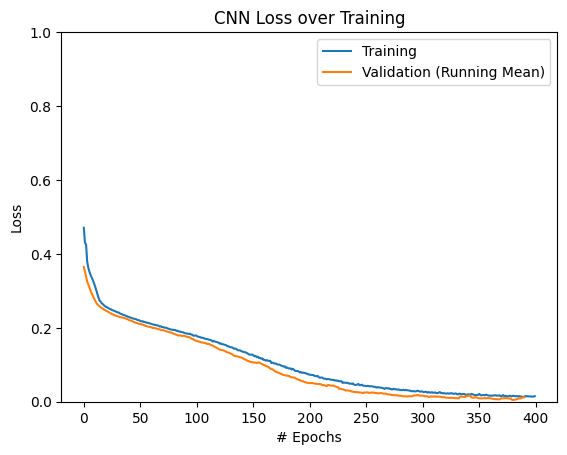

In [12]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(10)/10, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('CNN Loss over Training')

In [13]:
y_pred = model.predict(cnn_reshape(x_val))
((y_pred > .5) == y_val).mean(), ((y_pred > .5) == y_val).all(axis=1).mean()

148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(0.9989010989010989, 0.9945054945054945)

## Grad-CAM

In [14]:
i_s = np.random.choice(y.shape[0], 5000, replace=False)

x_i = x[i_s,:]

last_conv_i = 0
for i in range(len(model.layers)-1, -1, -1):
    if type(model.layers[i]) == Conv1D:
        last_conv_i = i
        break

grad_model = Model(
    model.inputs,
    [model.get_layer(index=last_conv_i).output, model.get_layer(index=-1).output]
)

with tf.GradientTape() as tape:
    conv_output, preds = grad_model(x_i)
    
grads = tape.gradient(preds, conv_output)
pooled_grads = tf.reduce_mean(grads, axis=(0,1))
heatmap = conv_output @ pooled_grads[...,tf.newaxis]
heatmap = heatmap.numpy().reshape((heatmap.shape[0], heatmap.shape[1]))
heatmap = (heatmap - heatmap.min(axis=1)[...,np.newaxis]) / (heatmap.max(axis=1) - heatmap.min(axis=1))[...,np.newaxis]

Text(0.5, 0.98, 'Grad-CAM Results')

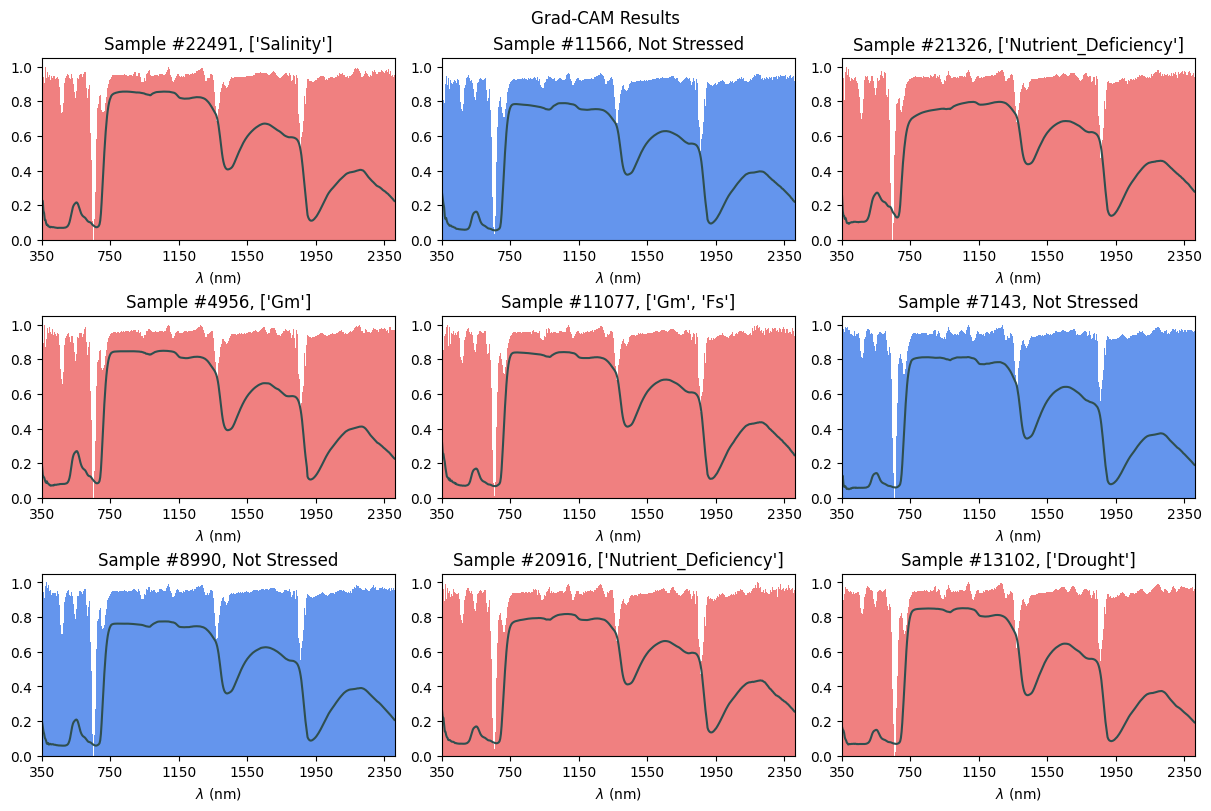

In [15]:
# i_s = i_s[y[i_s,2]]

x_h = spec_cols[::blur_factor][:heatmap.shape[1]]
x_h = [int(e[1:]) for e in x_h]
x_r = np.arange(0,len(heatmap[0]),1)
x_s = drop_res(x[i_s], blur_factor=blur_factor)[:,:len(x_h)]
q = df.loc[i_s, stresses].values

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(12,8))

bar, line = None, None

i = 0
for row in axs:
    for ax in row:
        bar = ax.bar(x_r, heatmap[i], width=1, color=('lightcoral' if (y[i_s[i]]).any() else 'cornflowerblue'), label='Grad-CAM output')
        line = ax.plot(x_r, x_s[i], c='darkslategrey', label='Spectrograph')
        # ax.legend()
        ax.set_xticks(x_r[::100],labels=x_h[::100]);
        ax.set_title(f'Sample #{i_s[i]}, {[stresses[j] for j in range(q.shape[1]) if q[i,j]] if y[i_s[i]].any() else "Not Stressed"}')
        ax.set_xlim(ax.patches[0].get_x(), ax.patches[-1].get_x() + ax.patches[-1].get_width())
        ax.set_xlabel(r'$\lambda$ (nm)')
        
        i += 1

# fig.legend([bar, line], labels=['Grad-Cam output', 'Spectrograph'])
fig.suptitle('Grad-CAM Results')

## LRP

In [16]:
i_s = np.random.choice(x.shape[0], 100, replace=False)
temp_x = cnn_reshape(x[i_s])
activations = [temp_x]
for layer in model.layers:
    temp_x = layer(temp_x)
    activations.append(temp_x.numpy())

In [17]:
alpha = 2
beta = 1
epsilon = 1e-5

relevances = activations[-1]

last_flatten_i = 0
for i in range(len(model.layers)-1, -1, -1):
    if type(model.layers[i]) == Flatten:
        last_flatten_i = i
        break

for i in range(len(activations)-1, last_flatten_i + 1, -1):
    weights = np.ones((activations[i-1].shape[1], activations[i].shape[1]))
    biases = np.zeros((activations[i].shape[1],))
    
    if model.layers[i-1].weights:
        weights = model.layers[i-1].weights[0].numpy()
        biases = model.layers[i-1].weights[1].numpy()

    weights_p = weights * (weights > 0)
    weights_n = weights * (weights < 0)

    pre_activations_p = activations[i-1] @ weights_p
    pre_activations_n = activations[i-1] @ weights_n

    r = np.zeros(activations[i-1].shape)

    for j in range(activations[i-1].shape[1]):        
        r_a = activations[i-1][:,j,np.newaxis] * np.repeat(weights_p[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_p + epsilon)
        r_b = activations[i-1][:,j,np.newaxis] * np.repeat(weights_n[j,np.newaxis],activations[i-1].shape[0],axis=0) / (pre_activations_n + epsilon)

        r[:,j] = ((alpha * r_a - beta * r_b) * relevances[-1]).sum(axis=1)
    relevances = r

    print(i)

17
16
15
14
13
12
11
10
9
8
7


In [18]:
input_relevances = relevances
input_relevances = input_relevances.reshape((input_relevances.shape[0], -1, model.layers[last_conv_i].filters)).mean(axis=2)
input_relevances = (input_relevances - input_relevances.min(axis=0))/(input_relevances.max(axis=0) - input_relevances.min(axis=0))

Text(0.5, 0.98, 'LRP Results, $\\alpha$=2 $\\beta$=1')

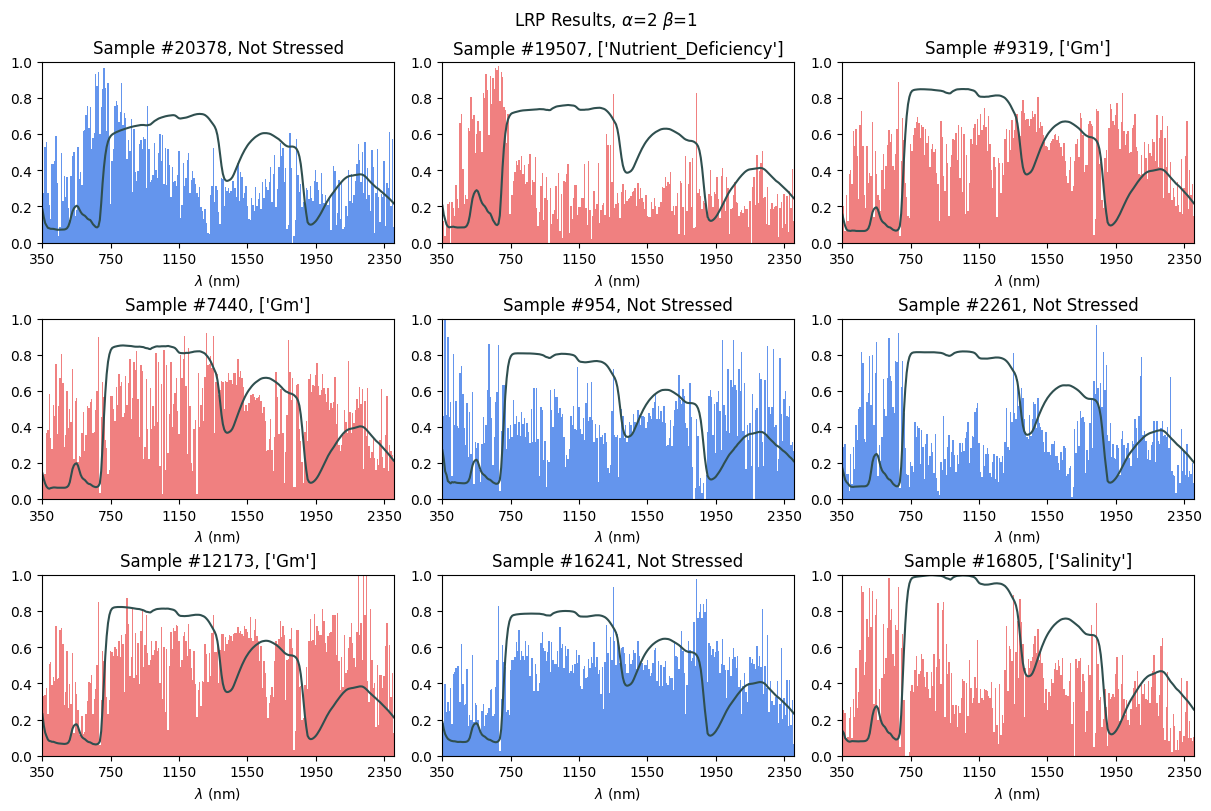

In [19]:
i_s_stressed = np.random.choice(i_s.shape[0], 9, replace=False)

x_h = spec_cols[::blur_factor*2][:input_relevances.shape[1]]
x_h = [int(e[1:]) for e in x_h]
x_r = np.arange(0,len(input_relevances[0]),1)
x_s = drop_res(x[i_s], blur_factor=blur_factor*2)[:,:len(x_h)]
q = df.loc[i_s, stresses].values

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(12,8))

bar, line = None, None

i = 0
for row in axs:
    for ax in row:
        bar = ax.bar(x_r, input_relevances[i_s_stressed[i]], width=1, color=('lightcoral' if (y[i_s[i_s_stressed[i]]]).any() else 'cornflowerblue'), label='LRP output')
        line = ax.plot(x_r, x_s[i_s_stressed[i]], c='darkslategrey', label='Spectrograph')
        # ax.legend()
        ax.set_xticks(x_r[::50],labels=x_h[::50]);
        ax.set_title(f'Sample #{i_s[i_s_stressed[i]]}, {[stresses[j] for j in range(q.shape[1]) if q[i_s_stressed[i],j]] if y[i_s[i_s_stressed[i]]].any() else "Not Stressed"}')
        ax.set_xlim(ax.patches[0].get_x(), ax.patches[-1].get_x() + ax.patches[-1].get_width())
        ax.set_ylim((0,1))
        ax.set_xlabel(r'$\lambda$ (nm)')
        
        i += 1

# fig.legend([bar, line], labels=['Grad-Cam output', 'Spectrograph'])
fig.suptitle(f'LRP Results, $\\alpha$={alpha} $\\beta$={beta}')

In [20]:
drop_res(x[i_s], blur_factor=blur_factor).shape

(100, 537)